In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
from sqlalchemy import desc

# Reflect Tables into SQLAlchemy ORM

In [15]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from flask import Flask,jsonify

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Using inspector to get the columns

In [11]:
inspector = inspect(engine)
columns=inspector.get_columns('measurement')
for m in columns:
    print(m['name'],m['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
columns=inspector.get_columns('station')
for s in columns:
    print(s['name'],s['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [26]:
import datetime as dt

In [27]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [28]:
start_date=dt.date(2017, 8, 23) - dt.timedelta(days=365)
start_date

datetime.date(2016, 8, 23)

In [29]:
# Perform a query to retrieve the data and precipitation scores
# Sort the dataframe by date
response=session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>=start_date).order_by(Measurement.date).all()

In [30]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df=pd.DataFrame(response, columns=['date','precipitation']).dropna().reset_index(drop=True)
df.head()

,date,precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,0.02
4,2016-08-23,1.79


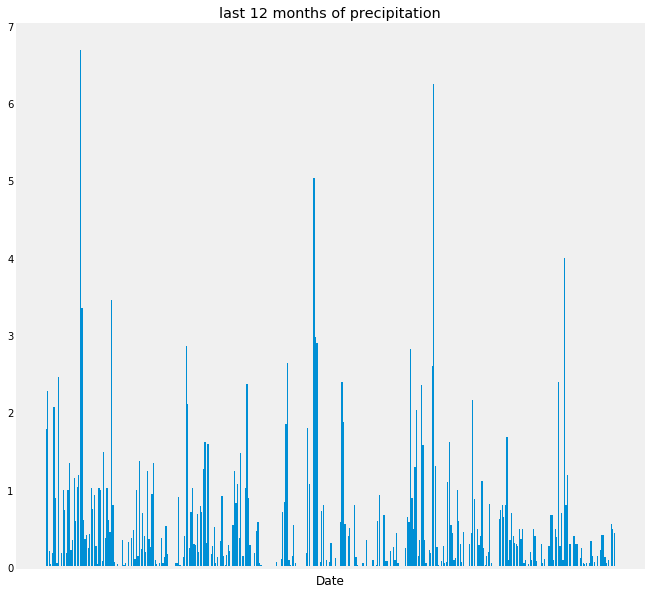

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(10, 10))
bar=plt.bar(df['date'],df['precipitation'])
plt.grid()
ax.set_xticklabels([])
ax.set_xlabel("Date")
ax.set_title("last 12 months of precipitation")
plt.show()

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
count=df['precipitation'].count()
mean=df['precipitation'].mean()
std=df['precipitation'].std()
min=df['precipitation'].min()
q25 = np.percentile(df['precipitation'], 25)
q50 = np.percentile(df['precipitation'], 50)
q75 = np.percentile(df['precipitation'],75)
max= df['precipitation'].max()
dic={"count":count,"mean":mean,"std":std,"min":min,"25%":q25,"50%":q50,"75%":q75,"max":max}
stat=pd.DataFrame(dic,[0])
stat

,count,mean,std,min,25%,50%,75%,max
0,2021,0.177279,0.46119,0.0,0.0,0.02,0.13,6.7


In [20]:
# Design a query to show how many stations are available in this dataset?
nstation=len(session.query(Station.station).all())
nstation

9

In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(Measurement.station,func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).filter(Measurement.station=='USC00519281').all()

[('USC00519281', 54.0, 71.66378066378067, 85.0)]

In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#I just want to practice doing it using another way. 
htob=engine.execute('SELECT measurement.station, count(measurement.tobs) as count FROM measurement GROUP BY measurement.station').fetchall()
htob_station=pd.DataFrame(htob,columns=['Station ID','number of temperature observations']).dropna()
htob_station=htob_station.sort_values('number of temperature observations',ascending=False).reset_index(drop=True)
htob_station

,Station ID,number of temperature observations
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DA0C534F28>]],
      dtype=object)

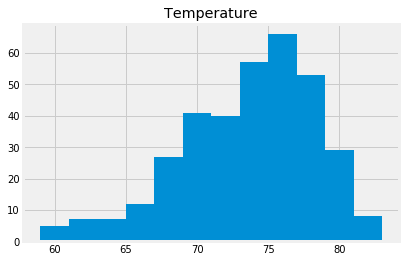

In [24]:
htob_tob=session.query(Measurement.station,Measurement.tobs).filter(Measurement.date>='2016-08-23').filter(Measurement.station=='USC00519281').all()
htob_graph=pd.DataFrame(htob_tob,columns=['Station ID','Temperature'])
htob_graph.hist(grid=True,bins=12)

## Optional Challenge Assignment

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [37]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# function usage example
answer=calc_temps('2017-02-28', '2017-03-05')
print(calc_temps('2017-02-28', '2017-03-05'))

[(64.0, 72.02777777777777, 78.0)]


In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
df=pd.DataFrame(answer,columns=['Min','Avg','Max'])
df['Peak_to_Peak']=df['Max']-df['Min']
df

,Min,Avg,Max,Peak_to_Peak
0,64.0,72.027778,78.0,14.0


[]

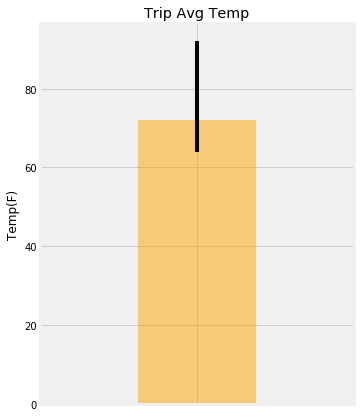

In [28]:
fig, ax = plt.subplots(figsize=(5, 7))
df['Avg'].plot.bar(width=0.3,alpha=0.5,color="orange")
plt.errorbar(0,df['Max'],yerr=df['Peak_to_Peak'],color="black")
ax.set_ylabel("Temp(F)")
ax.set_title("Trip Avg Temp")
ax.set_xticklabels([])

In [29]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_start='2017-04-05'
trip_end='2017-04-15'

name=[]
latitude=[]
longitude=[]
elevation=[]
prcp=[]

response=session.query(Measurement, Station).filter(Measurement.station==Station.station).\
filter(Measurement.date>=trip_start).filter(Measurement.date<=trip_end).all()



for record in response:
    (measurement,station)=record
    
    name.append(station.name)
    latitude.append(station.latitude)
    longitude.append(station.longitude)
    elevation.append(station.elevation)
    prcp.append(measurement.prcp)

dic={"name":name,"latitude":latitude,"longitude":longitude,"elevation":elevation,"prcp":prcp}
final=pd.DataFrame(dic)
final.head()

,name,latitude,longitude,elevation,prcp
0,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,0.0
1,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,0.0
2,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,0.0
3,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,0.0
4,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,0.0


In [30]:
group=final[['name','prcp']].groupby('name').sum().sort_values('prcp',ascending=False).reset_index(drop=False)
merge=pd.merge(group,final[['name','latitude','longitude','elevation']],how="left",on="name").drop_duplicates()
merge

,name,prcp,latitude,longitude,elevation
0,"MANOA LYON ARBO 785.2, HI US",5.30,21.33310,-157.80250,152.4
10,"WAIHEE 837.5, HI US",3.58,21.45167,-157.84889,32.9
21,"KANEOHE 838.1, HI US",1.52,21.42340,-157.80150,14.6
32,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.81,21.52130,-157.83740,7.0
41,"WAIMANALO EXPERIMENTAL FARM, HI US",0.36,21.33556,-157.71139,19.5
51,"WAIKIKI 717.2, HI US",0.27,21.27160,-157.81680,3.0
62,"PEARL CITY, HI US",0.00,21.39340,-157.97510,11.9


In [31]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [36]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
trip_start='2017-04-05'
trip_end='2017-04-15'
list_date=[]
results=session.query(Measurement.date).filter(Measurement.date>=trip_start).filter(Measurement.date<=trip_end).group_by(Measurement.date).all()
for result in results:
    date=result[0][5:10]
    list_date.append(date)
list_date

['04-05',
 '04-06',
 '04-07',
 '04-08',
 '04-09',
 '04-10',
 '04-11',
 '04-12',
 '04-13',
 '04-14',
 '04-15']

In [53]:
tmin=[]
tavg=[]
tmax=[]
date_n=[]
for date in list_date:
    date_n.append(date)
    normals=daily_normals(date)
    for data in normals:
        tmin.append(data[0])
        tavg.append(data[1])
        tmax.append(data[2])

In [58]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df=pd.DataFrame({"date":date_n,"tmin":tmin,"tavg":tavg,"tmax":tmax}).set_index('date')
df

,tmin,tavg,tmax
date,,,
04-05,61.0,72.288136,80.0
04-06,67.0,71.571429,77.0
04-07,63.0,71.105263,78.0
04-08,66.0,72.105263,77.0
04-09,62.0,71.614035,78.0
04-10,64.0,71.403509,79.0
04-11,65.0,72.491803,82.0
04-12,65.0,72.224138,80.0
04-13,64.0,71.525424,79.0


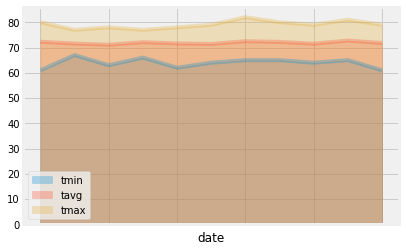

In [64]:
# Plot the daily normals as an area plot with `stacked=False`
ax = df.plot.area(stacked=False,alpha=0.3)